

Make tables for comparing months:

- (3-4) March vs April
- (4-5) April vs May
- (5-6) May vs June

where each table has form:
```
county FIPs, month (int), new cases change, contacts change, trips change, ...others
```
where change is relative to month and county:

```
= [(aggregated sum for month i) - (aggregated sum for month (i-1)]/(aggregated sum for month (i-1)
```


To get there... make a table with

```
county FIPs, month (int), new cases, contacts, trips, whatever other mobility metrics...
```

by first creating separate tables indexed by county FIPs and month


In [347]:
import datetime
import math
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

datapath = '/data/covid/'
metro_area_to_id = {
    'New York':35620,
    'Seattle':42660,
    'Dallas':19100,
    'Washington':47900,
    'Houston':26420,
    'Chicago':16980,
    'Miami':33100,
    'LA':31080,
    'Boston':14460,
    'San Francisco':41860,
    'Philadelphia':37980,
}
use_metros = [
    'Dallas',
    'Seattle',
    'Washington',
    'New York',
    'Miami',
    'Boston',
    'LA',
]

DATE = 'date'
FIPS = 'county FIPS'
NAME='county name'
METRO_AREA = 'metro area'
GEOID  = 'GEOID'
DAY = 'day'
MONTH = 'month'
CONTACTS  = 'contacts'
TRIPS = 'trips'
POPULATION = 'population'
POP_DENSITY = 'population density'


date_fmt = '%Y-%m-%d'


%config InlineBackend.figure_format = 'retina'

### Tables for mobility metrics

In [13]:
def get_county_contacts_trips_filepath(area):
    return datapath + str(area) + '/county_contacts_trips.csv'

In [348]:
metro_area_to_county_data = {}
for metro_area in use_metros:
    area_id = metro_area_to_id[metro_area]
    fpath = get_county_contacts_trips_filepath(area_id)
    df = pd.read_csv(fpath,
                    parse_dates=[DAY])
    df[FIPS] = df[FIPS].astype(str)
    metro_area_to_county_data[metro_area] = df
    print('loaded previously saved data for %s (%s)' % (metro_area, area_id))

loaded previously saved data for Dallas (19100)
loaded previously saved data for Seattle (42660)
loaded previously saved data for Washington (47900)
loaded previously saved data for New York (35620)
loaded previously saved data for Miami (33100)
loaded previously saved data for Boston (14460)
loaded previously saved data for LA (31080)


In [349]:
# make a big table with it all

metro_county_contacts_trips = None

for metro_area,df in metro_area_to_county_data.items():
    df = df[[FIPS, DAY, CONTACTS, TRIPS]]
    df[METRO_AREA]=metro_area
    if metro_county_contacts_trips is None:
        metro_county_contacts_trips = df
    else:
        metro_county_contacts_trips=metro_county_contacts_trips.append(df)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [350]:
# There is a problem with data for March 31 - remove it.
bad_date = datetime.date(2020, 3, 31).strftime(date_fmt)
metro_county_contacts_trips[metro_county_contacts_trips[DAY]!=bad_date]
print('removed from data: %s' % bad_date)

removed from data: 2020-03-31


In [351]:
metro_county_contacts_trips.head()

,county FIPS,day,contacts,trips,metro area
0,48085,2020-02-17,300169.0,108837.0,Dallas
1,48113,2020-02-17,243605.0,144136.0,Dallas
2,48121,2020-02-17,272963.0,97936.0,Dallas
3,48139,2020-02-17,46996.0,24333.0,Dallas
4,48221,2020-02-17,8033.0,6673.0,Dallas


## Making new reported cases table

In [352]:
NEW_CASES = 'new cases'
CUMULATIVE_CASES = 'cumulative cases'
STATE = 'state'

In [354]:
counties_cases_data_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

counties_cases_df = pd.read_csv(counties_cases_data_url,
                     usecols=[0,1,2,3,4],
                     parse_dates=[DATE],
                     dtype={'fips':'str'},
                     squeeze=True).sort_index()

counties_cases_df.sort_values(DATE, ascending=False).head(2)

,date,county,state,fips,cases
322650,2020-07-12,Weston,Wyoming,56045,1
320565,2020-07-12,Elliott,Kentucky,21063,3


In [355]:
counties_cases_df.columns = [DAY,NAME,STATE,FIPS,CUMULATIVE_CASES]
counties_cases_df.head(2)

,day,county name,state,county FIPS,cumulative cases
0,2020-01-21,Snohomish,Washington,53061,1
1,2020-01-22,Snohomish,Washington,53061,1


In [356]:
# Handle that the NY Times data source combines the New York City counties data

NYC = 'New York City'
NYC_FAKE_FIPS = '99999'
NYC_REAL_FIPS = ['36005', '36047', '36061', '36081', '36085']

counties_cases_df.loc[(counties_cases_df[NAME] == NYC), FIPS] = NYC_FAKE_FIPS
counties_cases_df[counties_cases_df[NAME] == NYC].head()

,day,county name,state,county FIPS,cumulative cases
416,2020-03-01,New York City,New York,99999,1
448,2020-03-02,New York City,New York,99999,1
482,2020-03-03,New York City,New York,99999,2
518,2020-03-04,New York City,New York,99999,2
565,2020-03-05,New York City,New York,99999,4


 remove the NYC rows  from df and add back in combined version

In [357]:
nyc_df = metro_county_contacts_trips[metro_county_contacts_trips[FIPS].isin(NYC_REAL_FIPS)]
nyc_df = nyc_df.groupby(DAY).sum().reset_index()
nyc_df[FIPS] = NYC_FAKE_FIPS
nyc_df[METRO_AREA] = 'New York'
nyc_df.head()

,day,contacts,trips,county FIPS,metro area
0,2020-02-17,520245.0,274472.0,99999,New York
1,2020-02-18,449097.0,285799.0,99999,New York
2,2020-02-19,507153.0,302922.0,99999,New York
3,2020-02-20,500332.0,302501.0,99999,New York
4,2020-02-21,487110.0,301999.0,99999,New York


In [358]:
print(metro_county_contacts_trips.shape)
metro_county_contacts_trips.head()

(10032, 5)


,county FIPS,day,contacts,trips,metro area
0,48085,2020-02-17,300169.0,108837.0,Dallas
1,48113,2020-02-17,243605.0,144136.0,Dallas
2,48121,2020-02-17,272963.0,97936.0,Dallas
3,48139,2020-02-17,46996.0,24333.0,Dallas
4,48221,2020-02-17,8033.0,6673.0,Dallas


In [359]:
metro_county_contacts_trips = metro_county_contacts_trips[~metro_county_contacts_trips[FIPS].isin(NYC_REAL_FIPS)]
print(metro_county_contacts_trips.shape)
metro_county_contacts_trips.head()

(9372, 5)


,county FIPS,day,contacts,trips,metro area
0,48085,2020-02-17,300169.0,108837.0,Dallas
1,48113,2020-02-17,243605.0,144136.0,Dallas
2,48121,2020-02-17,272963.0,97936.0,Dallas
3,48139,2020-02-17,46996.0,24333.0,Dallas
4,48221,2020-02-17,8033.0,6673.0,Dallas


In [360]:
metro_county_contacts_trips = metro_county_contacts_trips.append(nyc_df)
print(metro_county_contacts_trips.shape)
metro_county_contacts_trips.head()

(9504, 5)


,contacts,county FIPS,day,metro area,trips
0,300169.0,48085,2020-02-17,Dallas,108837.0
1,243605.0,48113,2020-02-17,Dallas,144136.0
2,272963.0,48121,2020-02-17,Dallas,97936.0
3,46996.0,48139,2020-02-17,Dallas,24333.0
4,8033.0,48221,2020-02-17,Dallas,6673.0


In [361]:
metro_county_contacts_trips[metro_county_contacts_trips[FIPS]==NYC_FAKE_FIPS].head()

,contacts,county FIPS,day,metro area,trips
0,520245.0,99999,2020-02-17,New York,274472.0
1,449097.0,99999,2020-02-18,New York,285799.0
2,507153.0,99999,2020-02-19,New York,302922.0
3,500332.0,99999,2020-02-20,New York,302501.0
4,487110.0,99999,2020-02-21,New York,301999.0


In [362]:
counties_cases_df = counties_cases_df.set_index([FIPS,DAY])

In [363]:
metro_county_contacts_trips = metro_county_contacts_trips.set_index([FIPS,DAY])

In [364]:
counties_cases_df[NEW_CASES] = counties_cases_df.groupby(level=0)[CUMULATIVE_CASES].diff().fillna(0)
counties_cases_df[counties_cases_df[NEW_CASES] != 0].head()

,,county name,state,cumulative cases,new cases
county FIPS,day,,,,
17031,2020-01-30,Cook,Illinois,2,1.0
06085,2020-02-02,Santa Clara,California,2,1.0
48029,2020-02-13,Bexar,Texas,2,1.0
31055,2020-02-20,Douglas,Nebraska,11,1.0
48029,2020-02-21,Bexar,Texas,4,2.0


In [366]:
county_cases_contacts_trips = metro_county_contacts_trips.reset_index().merge(
    counties_cases_df.reset_index(),
    on=[FIPS,DAY]
).set_index([FIPS,DAY])

county_cases_contacts_trips.head()

contacts metro area     trips county name  state  \
county FIPS day                                                            
48085       2020-03-09  157187.0     Dallas   80224.0      Collin  Texas   
            2020-03-10  150796.0     Dallas   85743.0      Collin  Texas   
48113       2020-03-10  147003.0     Dallas  123994.0      Dallas  Texas   
48439       2020-03-10  222569.0     Dallas  147966.0     Tarrant  Texas   
48085       2020-03-11  177690.0     Dallas   88203.0      Collin  Texas   

                        cumulative cases  new cases  
county FIPS day                                      
48085       2020-03-09                 1        0.0  
            2020-03-10                 3        2.0  
48113       2020-03-10                 2        0.0  
48439       2020-03-10                 1        0.0  
48085       2020-03-11                 3        0.0

aggregate by month

In [367]:
county_cases_contacts_trips = county_cases_contacts_trips.reset_index()
county_cases_contacts_trips[MONTH]= county_cases_contacts_trips[DAY].apply(lambda d: d.month)
county_cases_contacts_trips.head()

,county FIPS,day,contacts,metro area,trips,county name,state,cumulative cases,new cases,month
0,48085,2020-03-09,157187.0,Dallas,80224.0,Collin,Texas,1,0.0,3
1,48085,2020-03-10,150796.0,Dallas,85743.0,Collin,Texas,3,2.0,3
2,48113,2020-03-10,147003.0,Dallas,123994.0,Dallas,Texas,2,0.0,3
3,48439,2020-03-10,222569.0,Dallas,147966.0,Tarrant,Texas,1,0.0,3
4,48085,2020-03-11,177690.0,Dallas,88203.0,Collin,Texas,3,0.0,3


In [368]:
monthly_sum_county_cases_contacts_trips = county_cases_contacts_trips.groupby(
    [FIPS,STATE,NAME,METRO_AREA,MONTH]
).sum().reset_index()
monthly_sum_county_cases_contacts_trips.head()

,county FIPS,state,county name,metro area,month,contacts,trips,cumulative cases,new cases
0,11001,District of Columbia,District of Columbia,Washington,3,114266.0,199403.0,2923,494.0
1,11001,District of Columbia,District of Columbia,Washington,4,36794.0,132546.0,70950,3828.0
2,11001,District of Columbia,District of Columbia,Washington,5,44773.0,156200.0,215106,4478.0
3,11001,District of Columbia,District of Columbia,Washington,6,49134.0,161037.0,260961,1415.0
4,12011,Florida,Broward,Miami,3,3023956.0,1894976.0,7199,1217.0


In [369]:
monthly_median_county_cases_contacts_trips = county_cases_contacts_trips.groupby(
    [FIPS,STATE,NAME,METRO_AREA,MONTH]
).median().reset_index()
monthly_median_county_cases_contacts_trips.head()

,county FIPS,state,county name,metro area,month,contacts,trips,cumulative cases,new cases
0,11001,District of Columbia,District of Columbia,Washington,3,1825.0,6705.0,39.0,6.0
1,11001,District of Columbia,District of Columbia,Washington,4,1139.5,4397.0,2273.5,122.0
2,11001,District of Columbia,District of Columbia,Washington,5,1345.0,4926.0,7042.0,139.0
3,11001,District of Columbia,District of Columbia,Washington,6,1495.0,5788.0,9767.0,52.0
4,12011,Florida,Broward,Miami,3,52902.0,64388.5,88.0,20.5


In [370]:
monthly_sum_change_tables = {}
monthly_median_change_tables = {}

In [371]:
months = [4,5,6]
PREV_MONTH='prev month'
CHANGE_PREFIX = 'change in '

In [372]:
change_metric_names = set()

In [373]:
# 
df = monthly_sum_county_cases_contacts_trips
for m in months:
    prev_month = m-1
    prev_m_df = df[df[MONTH]==prev_month].set_index(FIPS)
    m_df = df[df[MONTH]==m].set_index(FIPS)
    for metric in [NEW_CASES, CONTACTS, TRIPS]:
        change_metric_name = CHANGE_PREFIX+metric
        change_metric_names.add(change_metric_name)
        m_df[change_metric_name] =  (m_df[metric] - prev_m_df[metric])/prev_m_df[metric]
        m_df[PREV_MONTH] = prev_month
    
    m_df = m_df[[NAME,STATE,METRO_AREA]+list(change_metric_names)]
    monthly_sum_change_tables[(prev_month,m)] = pd.DataFrame(m_df)

In [374]:
# same for medians
df = monthly_median_county_cases_contacts_trips
change_metric_names = set()
for m in months:
    prev_month = m-1
    prev_m_df = df[df[MONTH]==prev_month].set_index(FIPS)
    m_df = df[df[MONTH]==m].set_index(FIPS)
    for metric in [NEW_CASES, CONTACTS, TRIPS]:
        change_metric_name = CHANGE_PREFIX+metric
        change_metric_names.add(change_metric_name)
        m_df[change_metric_name] =  (m_df[metric] - prev_m_df[metric])/prev_m_df[metric]
        m_df[PREV_MONTH] = prev_month
    
    m_df = m_df[[NAME,STATE,METRO_AREA]+list(change_metric_names)]
    monthly_median_change_tables[(prev_month,m)] = pd.DataFrame(m_df)

In [429]:
for i, (m1, m2) in enumerate(sorted(monthly_median_change_tables.keys())):
    m_df = monthly_median_change_tables[(m1, m2)]
    print('\nmonths %s vs %s' %  (m1,m2))
    print(m_df.corr())


months 3 vs 4
                     change in contacts  change in trips  change in new cases
change in contacts             1.000000         0.835535            -0.355996
change in trips                0.835535         1.000000            -0.312850
change in new cases           -0.355996        -0.312850             1.000000

months 4 vs 5
                     change in contacts  change in trips  change in new cases
change in contacts             1.000000         0.399172            -0.000159
change in trips                0.399172         1.000000            -0.528247
change in new cases           -0.000159        -0.528247             1.000000

months 5 vs 6
                     change in contacts  change in trips  change in new cases
change in contacts             1.000000         0.835959            -0.310045
change in trips                0.835959         1.000000            -0.501323
change in new cases           -0.310045        -0.501323             1.000000


In [431]:
metro_areas = df[METRO_AREA].unique()

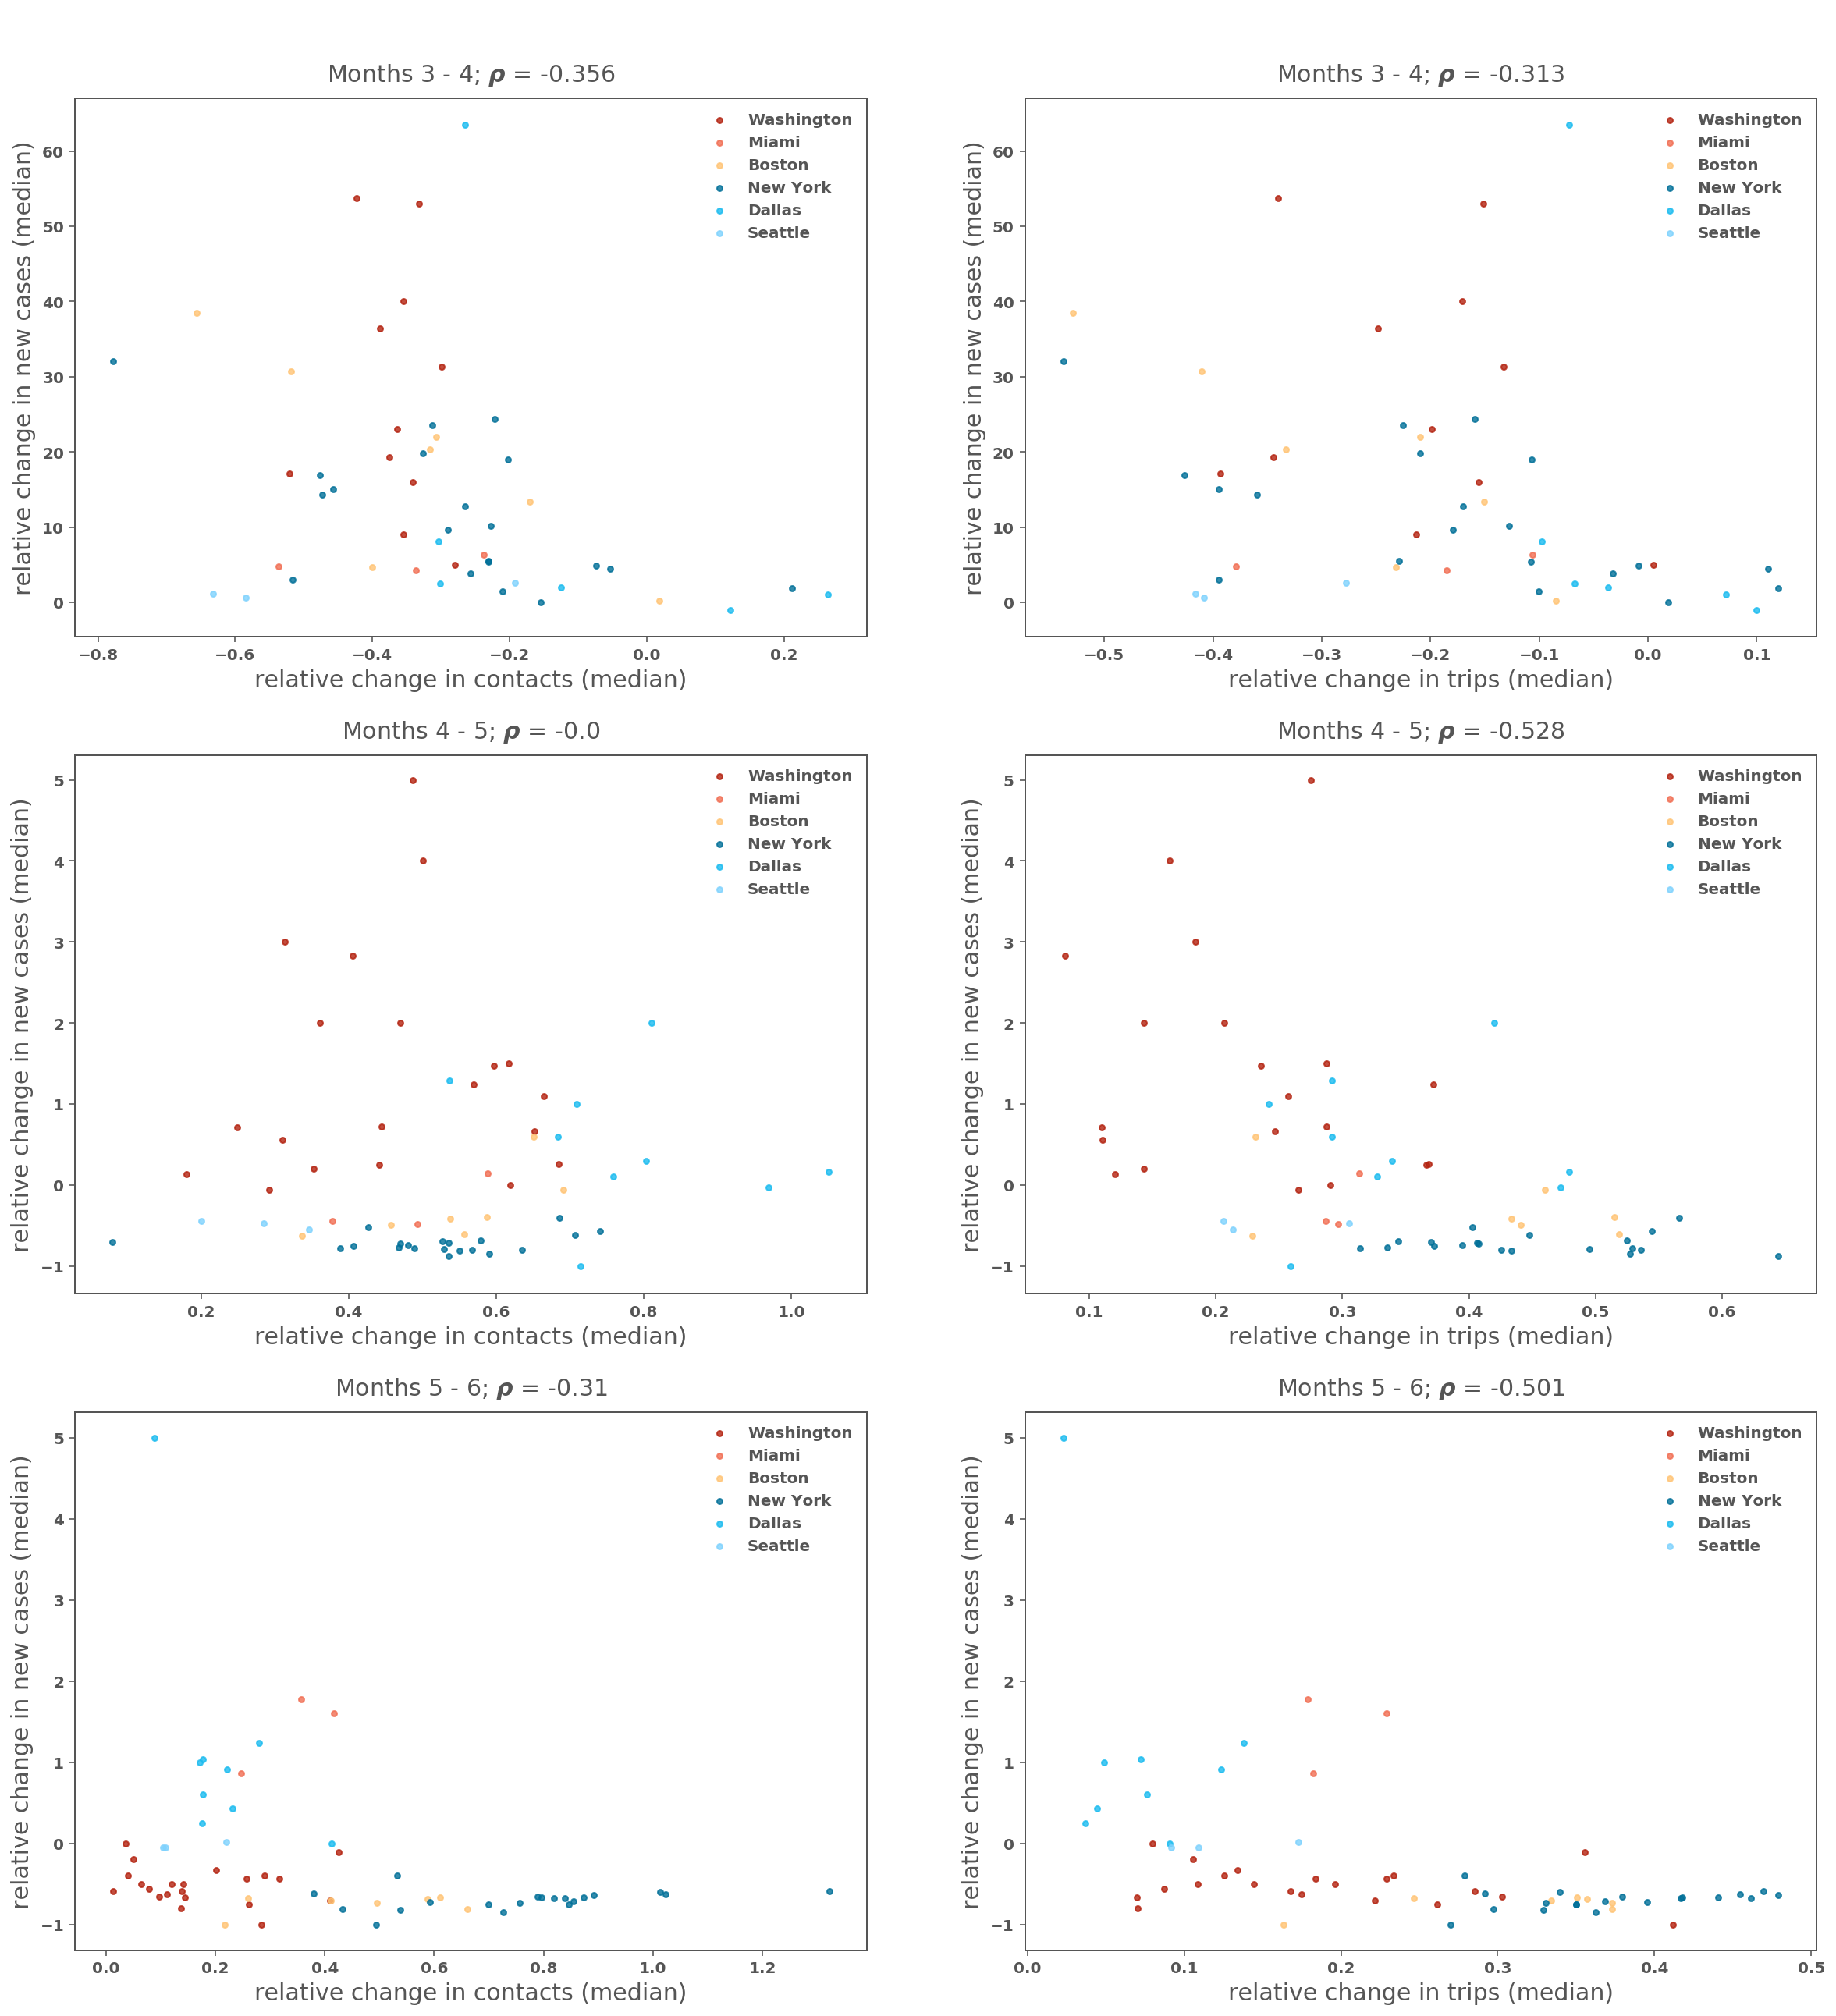

In [490]:
ncols = 2
nrows=len(monthly_median_change_tables)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*7))
plt.subplots_adjust(hspace=0.22)
s=12


pd.options.mode.use_inf_as_na = True

for i, (m1, m2) in enumerate(sorted(monthly_median_change_tables.keys())):
    m_df = monthly_median_change_tables[(m1, m2)]
    m_df = m_df.dropna(axis=0)
    for j, change_metric  in enumerate([CHANGE_PREFIX+CONTACTS, CHANGE_PREFIX+TRIPS]):
        ax = axes.flat[2*i+j]
        for metro_area in metro_areas:
            metro_df  = m_df[m_df[METRO_AREA]==metro_area]
            x = metro_df[change_metric]
            y = metro_df[CHANGE_PREFIX+NEW_CASES]
            ax.scatter(
                x,
                y,
                s=12,
                label=metro_area,
                alpha=0.8,
            )
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.set_xlabel('relative %s (median)' % change_metric, fontsize=15)
        ax.set_ylabel('relative %s (median)' % (CHANGE_PREFIX+NEW_CASES), fontsize=15)
        ax.legend()
        ax.get_figure().set_facecolor('w')
        x = m_df[change_metric]
        y = m_df[CHANGE_PREFIX+NEW_CASES]
        correlation  =  round(x.corr(y),3)
        title = '\n\nMonths %s - %s; $\\rho$ = %s' % (
                str(m1),str(m2),
                correlation
        )
        ax.set_title(title,fontsize=15)
plt.legend()
plt.show()

In [444]:
m12_df.head(2)

,county name,state,metro area,change in contacts,change in trips,change in new cases
county FIPS,,,,,,
11001,District of Columbia,District of Columbia,Washington,0.180342,0.120309,0.139344
12011,Broward,Florida,Miami,0.378115,0.286967,-0.445378


In [443]:
m23_df.head()

,county name,state,metro area,change in contacts,change in trips,change in new cases
county FIPS,,,,,,
11001,District of Columbia,District of Columbia,Washington,0.111524,0.174990,-0.625899
12011,Broward,Florida,Miami,0.416011,0.229304,1.606061
12086,Miami-Dade,Florida,Miami,0.247062,0.182384,0.862069
12099,Palm Beach,Florida,Miami,0.356178,0.178655,1.773810
24009,Calvert,Maryland,Washington,0.289199,0.233495,-0.400000


In [452]:
m12_df.reset_index().merge(m23_df.reset_index(),on=FIPS,suffixes=("","_1")).set_index(FIPS).head()

,county name,state,metro area,change in contacts,change in trips,change in new cases,county name_2,state_2,metro area_2,change in contacts_2,change in trips_2,change in new cases_2
county FIPS,,,,,,,,,,,,
11001,District of Columbia,District of Columbia,Washington,0.180342,0.120309,0.139344,District of Columbia,District of Columbia,Washington,0.111524,0.174990,-0.625899
12011,Broward,Florida,Miami,0.378115,0.286967,-0.445378,Broward,Florida,Miami,0.416011,0.229304,1.606061
12086,Miami-Dade,Florida,Miami,0.492991,0.296847,-0.482912,Miami-Dade,Florida,Miami,0.247062,0.182384,0.862069
12099,Palm Beach,Florida,Miami,0.588792,0.313498,0.142857,Palm Beach,Florida,Miami,0.356178,0.178655,1.773810
24009,Calvert,Maryland,Washington,0.441487,0.366439,0.250000,Calvert,Maryland,Washington,0.289199,0.233495,-0.400000


('change in contacts', 0.255)
('change in trips', 0.3)
('change in contacts', 0.396)
('change in trips', -0.142)


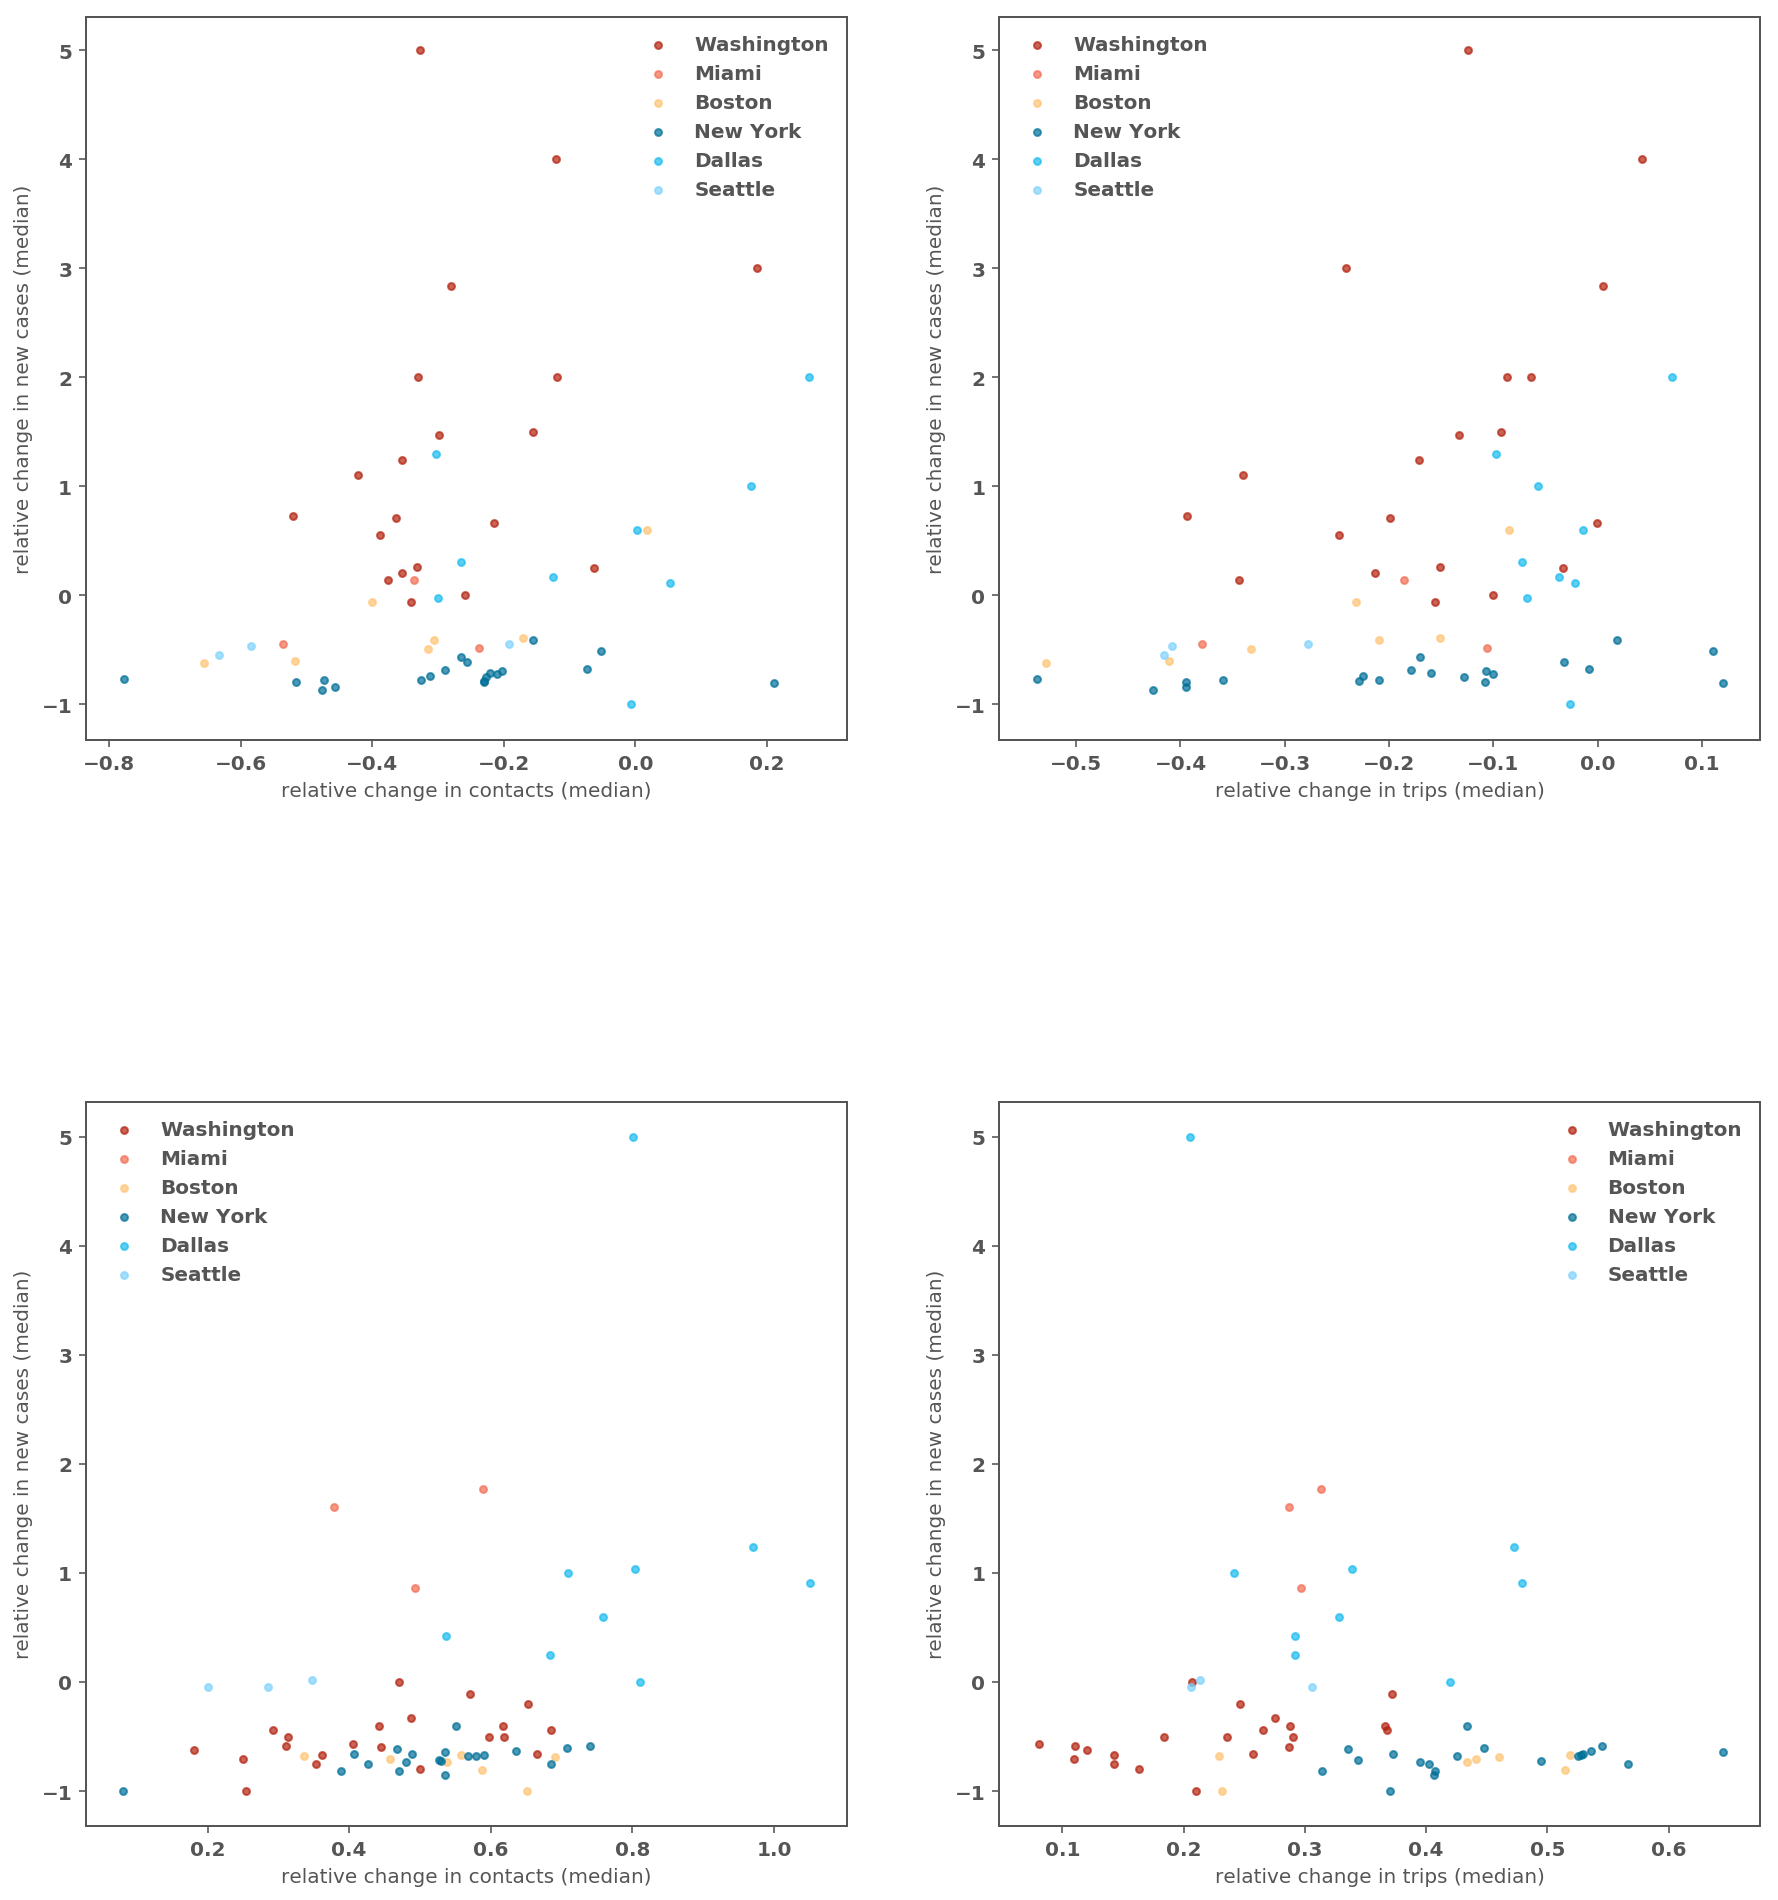

In [458]:
# compare change in months  to following change in months
ncols = 2
nrows=len(monthly_median_change_tables)-1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*8))
plt.subplots_adjust(hspace=0.5)
s=12


pd.options.mode.use_inf_as_na = True

for i, (m1, m2) in enumerate(sorted(monthly_median_change_tables.keys())[:-1]):
    m12_df = monthly_median_change_tables[(m1, m2)]
    m23_df = monthly_median_change_tables[(m1+1, m2+1)]
    merged = m12_df.reset_index().merge(m23_df.reset_index(),on=FIPS,suffixes=("","_1")).set_index(FIPS)
    for j, change_metric  in enumerate([CHANGE_PREFIX+CONTACTS, CHANGE_PREFIX+TRIPS]):
        ax = axes.flat[2*i+j]
        for metro_area in metro_areas:
            metro_merged_df =  merged[merged[METRO_AREA]==metro_area]
            x = metro_merged_df[change_metric]
            y = metro_merged_df[CHANGE_PREFIX+NEW_CASES+"_1"]
            ax.scatter(
                x,
                y,
                s=12,
                label=metro_area,
                alpha=0.7,
            )
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.set_xlabel('relative %s (median)' % change_metric)
        ax.set_ylabel('relative %s (median)' % (CHANGE_PREFIX+NEW_CASES))
        ax.legend()
        ax.get_figure().set_facecolor('w')
        x = merged[change_metric]
        y = merged[CHANGE_PREFIX+NEW_CASES+"_1"]
        correlation  =  round(x.corr(y),3)
        print(change_metric,  correlation)
        title =  ''# '\n\nMonths %s - %s\n'\
#             '%s vs %s\n' \
#             'corr = %s' % (
#                 str(m1),str(m2),
#                 change_metric, (CHANGE_PREFIX+NEW_CASES),
#                 correlation
#         )
#         ax.set_title(title)
plt.legend()
plt.show()

In [432]:
for i, (m1, m2) in enumerate(sorted(monthly_sum_change_tables.keys())):
    m_df = monthly_sum_change_tables[(m1, m2)]
    print('\nmonths %s vs %s' %  (m1,m2))
    print(m_df.corr())


months 3 vs 4
                     change in contacts  change in trips  change in new cases
change in contacts             1.000000         0.971866             0.424529
change in trips                0.971866         1.000000             0.440222
change in new cases            0.424529         0.440222             1.000000

months 4 vs 5
                     change in contacts  change in trips  change in new cases
change in contacts             1.000000         0.734153            -0.230136
change in trips                0.734153         1.000000            -0.432275
change in new cases           -0.230136        -0.432275             1.000000

months 5 vs 6
                     change in contacts  change in trips  change in new cases
change in contacts             1.000000         0.866353            -0.359917
change in trips                0.866353         1.000000            -0.565153
change in new cases           -0.359917        -0.565153             1.000000


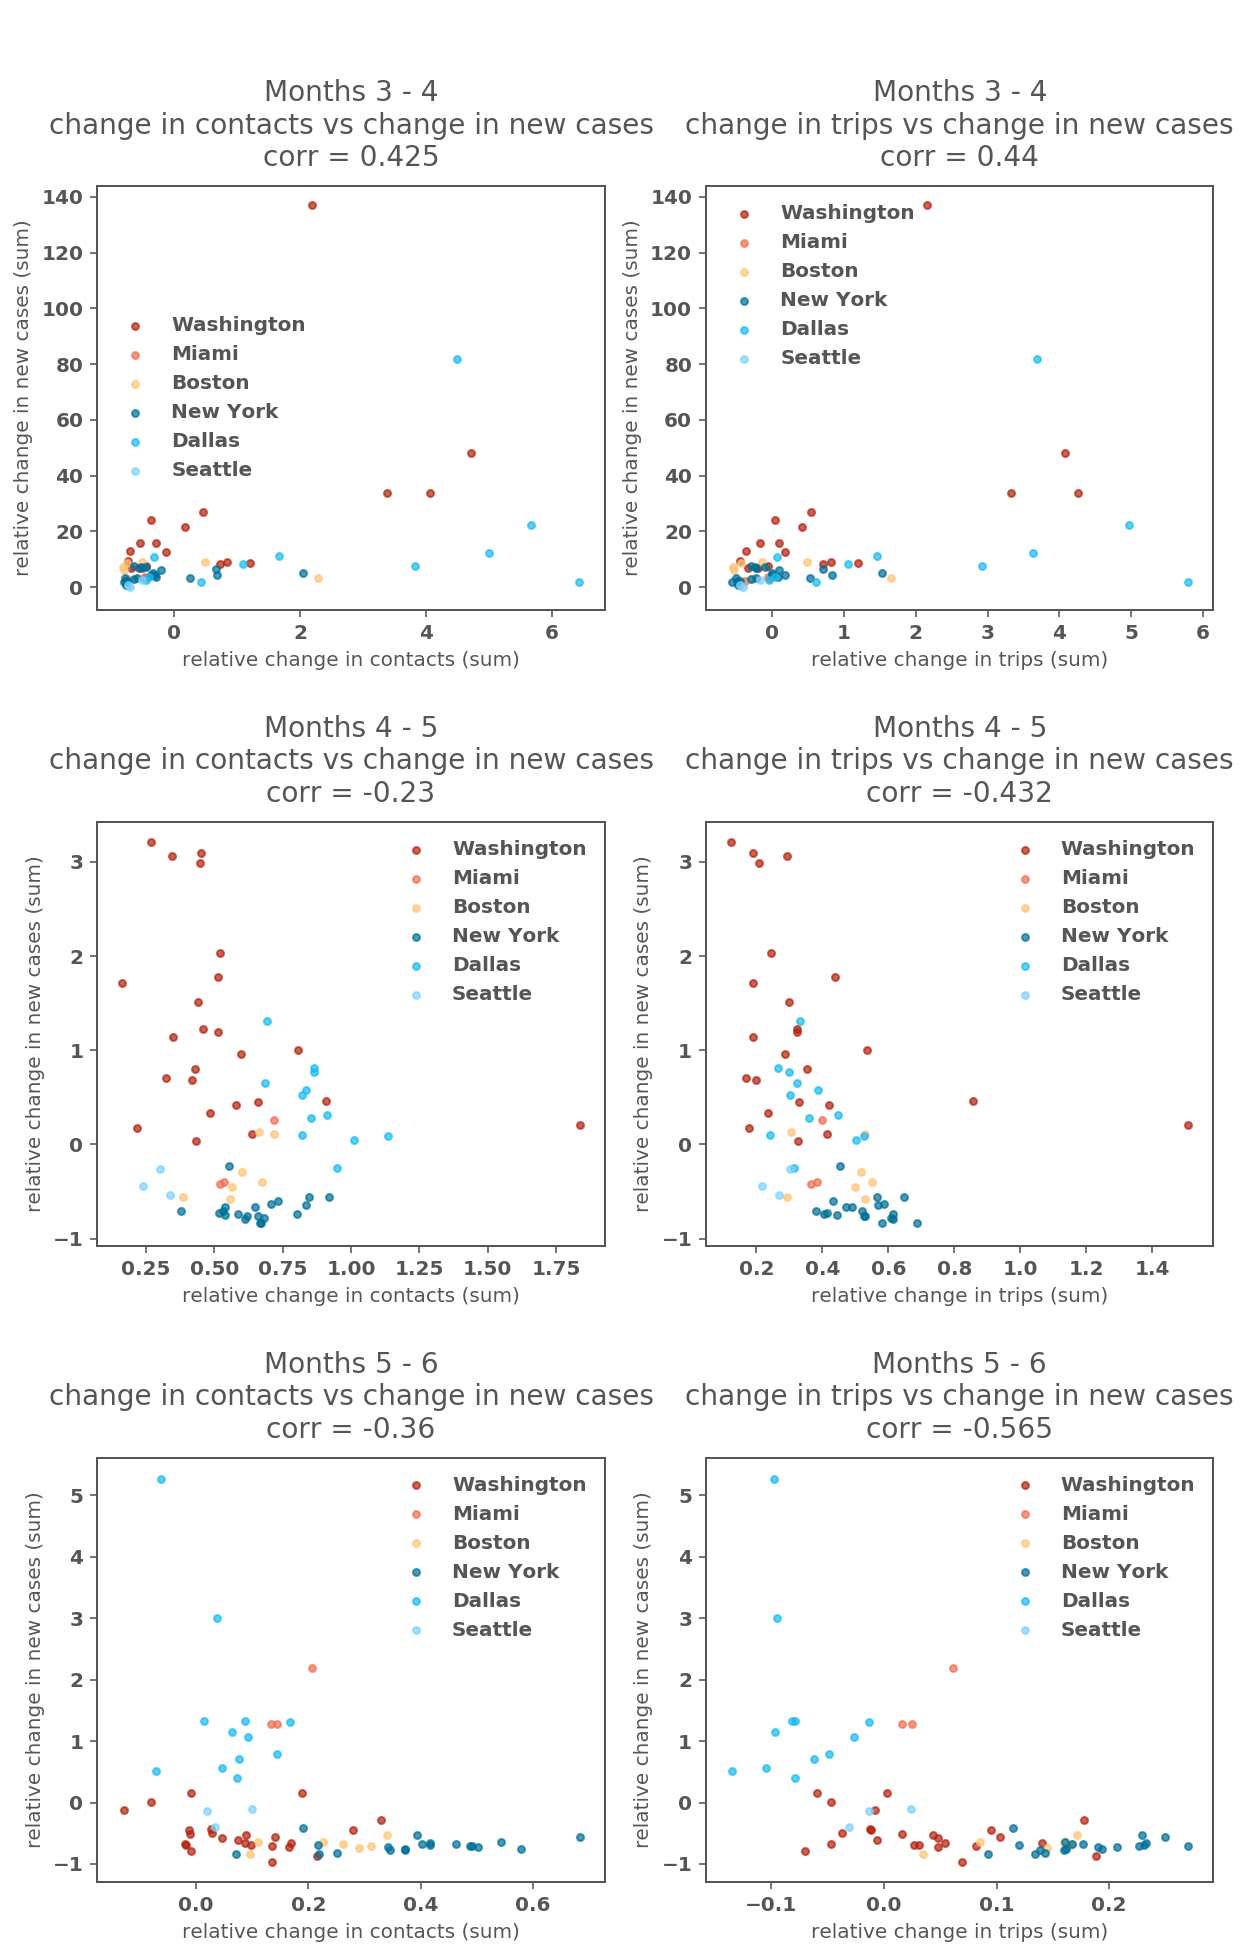

In [465]:
ncols = 2
nrows=len(monthly_sum_change_tables)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*5))
plt.subplots_adjust(hspace=0.5)
s=12


pd.options.mode.use_inf_as_na = True

for i, (m1, m2) in enumerate(sorted(monthly_sum_change_tables.keys())):
    m_df = monthly_sum_change_tables[(m1, m2)]
    m_df = m_df.dropna(axis=0)
    for j, change_metric  in enumerate([CHANGE_PREFIX+CONTACTS, CHANGE_PREFIX+TRIPS]):
        ax = axes.flat[2*i+j]
        for metro_area in metro_areas:
            metro_df  = m_df[m_df[METRO_AREA]==metro_area]
            x = metro_df[change_metric]
            y = metro_df[CHANGE_PREFIX+NEW_CASES]
            ax.scatter(
                x,
                y,
                s=12,
                label=metro_area,
                alpha=0.7,
            )
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.set_xlabel('relative %s (sum)' % change_metric)
        ax.set_ylabel('relative %s (sum)' % (CHANGE_PREFIX+NEW_CASES))
        ax.legend()
        ax.get_figure().set_facecolor('w')
        x = m_df[change_metric]
        y = m_df[CHANGE_PREFIX+NEW_CASES]
        correlation  =  round(x.corr(y),3)
        title = '\n\nMonths %s - %s\n'\
            '%s vs %s\n' \
            'corr = %s' % (
                str(m1),str(m2),
                change_metric, (CHANGE_PREFIX+NEW_CASES),
                correlation
        )
        ax.set_title(title)
plt.legend()
plt.show()

In [300]:
monthly_sum_change_tables

{(3, 4):                       county name                 state  metro area  \
 county FIPS                                                           
 11001        District of Columbia  District of Columbia  Washington   
 12011                     Broward               Florida       Miami   
 12086                  Miami-Dade               Florida       Miami   
 12099                  Palm Beach               Florida       Miami   
 24009                     Calvert              Maryland  Washington   
 24017                     Charles              Maryland  Washington   
 24021                   Frederick              Maryland  Washington   
 24031                  Montgomery              Maryland  Washington   
 24033             Prince George's              Maryland  Washington   
 25009                       Essex         Massachusetts      Boston   
 25017                   Middlesex         Massachusetts      Boston   
 25021                     Norfolk         Massachusetts